# seq2seq+attn 스페인-영어 번역기

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

## 데이터 불러오기

In [ ]:
path_to_zip = tf.keras.utils.get_file('spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', extract=True)

2654208/2638744 [==============================] - 0s 0us/step


In [ ]:
path_to_file = os.path.dirname(path_to_zip) + "/spa-eng/spa.txt"

In [ ]:
with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size : ", len(raw))
print("Example : ")

for sen in raw[0:100][::20]: print(">>", sen)

Data Size :  118964
Example : 
>> Go.	Ve.
>> Wait.	Esperen.
>> Hug me.	Abrázame.
>> No way!	¡Ni cagando!
>> Call me.	Llamame.


In [ ]:
raw[0]

'Go.\tVe.'

## 데이터 전처리 : 정제하기

In [ ]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence
    
    if e_token:
        sentence += ' <end>'

    return sentence

In [ ]:
enc_corpus = []
dec_corpus = []

num_examples = 30000

for pair in raw[:num_examples]:
    eng, spa = pair.split("\t")

    enc_corpus.append(preprocess_sentence(eng)) # 영어를 preprocess_sentence 함수를 통과해서 담아주세요.
    dec_corpus.append(preprocess_sentence(spa, s_token=True, e_token=True)) # 스페인어를 preprocess_sentence 함수를 통과해서 담아주세요.

print("English :", enc_corpus[100]) # 영어 텍스트
print("Spanish :", dec_corpus[100]) # 스페인 텍스트

English : go away !
Spanish : <start> salga de aqu ! <end>


## 데이터 전처리 : 토큰화

In [ ]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)                                         # 텍스트 -> 시퀀스
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')      # 패딩

    return tensor, tokenizer

In [ ]:
# 토큰화 : tokenize함수를 사용하여, encoder, decoder 각각을 통과해주세요.
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

# 훈련 데이터와 검증 데이터로 분리하기 (80/20) ---> test_size = 0.2
enc_train, enc_val, dec_train, dec_val = train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("English Vocab Size : ", len(enc_tokenizer.index_word))
print("Spanish Vocab Size : ", len(dec_tokenizer.index_word))

English Vocab Size :  4931
Spanish Vocab Size :  8893


# 모델 설계

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_decoder = tf.keras.layers.Dense(units)
        self.w_encoder = tf.keras.layers.Dense(units)
        self.w_combine = tf.keras.layers.Dense(1)
    
    def call(self, h_encoder, h_decoder):
        # h_enc shape : [batch x length x units]
        # h_dec shape : [batch x units]

        h_encoder = self.w_encoder(h_encoder)

        h_decoder = tf.expand_dims(h_decoder, 1)
        h_decoder = self.w_decoder(h_decoder)

        score = self.w_combine(tf.nn.tanh(h_decoder + h_encoder))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * h_decoder
        context_vector = tf.reduce_sum(context_vector, axis = 1)

        return context_vector, attention_weights

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)
        #print("컨텍스트 벡터의 차원 : ", context_vec.shape) #(64, 1024)
    
        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis= -1)

        out, h_dec = self.gru(out)
        #print("gru 차원 : ", out.shape) #(64, 1, 1024)
        
        out = tf.reshape(out, (-1, out.shape[2])) # (64, 1024)
        #print("변경된 out의 차원 : ", out.shape)
        out = self.fc(out) 
        #print("fc 거친 out의 차원 :", out.shape) # (64, 8894)

        return out, h_dec, attn

In [ ]:
# encoder와 decoder 단어장 크기 확인하기
batch_size = 64
src_vocab_size = len(enc_tokenizer.index_word) + 1
tgt_vocab_size = len(dec_tokenizer.index_word) + 1

units = 1024
embedding_dim = 512

encoder = Encoder(src_vocab_size, embedding_dim, units)
decoder = Decoder(tgt_vocab_size, embedding_dim, units)

'''
sample input 
tf. random.uniform으로 만들어서 모델에 들어가는 shape 확인하기 (encoder)
'''
sequence_len = 30

sample_enc = tf.random.uniform((batch_size, sequence_len))
sample_output = encoder(sample_enc)

print('Encoder Output: ', sample_output.shape)

'''
sample input 
tf. random.uniform으로 만들어서 모델에 들어가는 shape 확인하기 (decoder)
'''

sample_state = tf.random.uniform((batch_size, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((batch_size, 1)), sample_state, sample_output)

print('Decoder output :', sample_logits.shape)
print('Decoder Hidden state :', h_dec.shape)
print('Attention :', attn.shape)

Encoder Output:  (64, 30, 1024)
Decoder output : (64, 8894)
Decoder Hidden state : (64, 1024)
Attention : (64, 30, 1)


## 훈련하기 : Optimizer & loss

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') # 모델 출력값을 그대로 전달한다.

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real,0))
    loss = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss.dtype) # <PAD>
    loss *= mask

    return tf.reduce_mean(loss)

    #[ 0.1 0.2 0.7] ----> 2

## 훈련하기 : train_step 구하기

train step 학습과정
1. Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out을 생성
2. Decoder에 입력으로 전달할 토큰 문장 생성
3. t=0일 때, Decoder의 Hidden state는 Encoder의 Final state로 정의. h_dec = enc_out[:, -1]
4. 문장과 enc_out, Hidden state를 기반으로 다음단어 (t=1)예측 pred
5. 예측된 단어와 정답간의 loss을 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예측단어X)
6. 반복!

In [ ]:
@tf.function # 가속 연산
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape: # 학습하면서 발생한 모든 연산을 기록하는 테이프, 자동 미분
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

## 훈련하기 : 훈련시작하기

In [ ]:
from tqdm import tqdm
import random
                                                                                    # tqdm.tq7dm : verbose의 역할(tqdm 프로그래스 bar 만들기 -> verbose 대체)
epochs = 10

for epoch in range(epochs):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], batch_size))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+batch_size],
                                dec_train[idx:idx+batch_size],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

Epoch 10: 100%|██████████| 375/375 [00:45<00:00,  8.19it/s, Loss 0.6257]


In [ ]:
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
  bsz = src.shape[0]
  loss =0

  enc_out = encoder(src)
  h_dec = enc_out[:, -1]

  dec_src = tf.expand_dims([dec_tok.word_index['<start>']]* bsz, 1)

  for t in range(1, tgt.shape[1]):
    pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)
    loss += loss_function(tgt[:, t], pred)
    dec_src = tf.expand_dims(tgt[:, t], 1)

  batch_loss = (loss/int(tgt.shape[1]))

  return batch_loss

In [ ]:
# Training Process
from tqdm import tqdm

EPOCHS = 1

for epoch in range(EPOCHS):
  total_loss = 0

  idx_list = list(range(0, enc_train.shape[0], batch_size))
  random.shuffle(idx_list)
  t = tqdm(idx_list)

  for (batch, idx) in enumerate(t):
    batch_loss = train_step(enc_train[idx:idx+batch_size],
                            dec_train[idx:idx+batch_size],
                            encoder,
                            decoder,
                            optimizer,
                            dec_tokenizer)
    total_loss += batch_loss

  t.set_description_str('Epoch %2d' % (epoch +1))
  t.set_postfix_str('Loss %.4f' % (total_loss.numpy()/ (batch+1)))

  test_loss = 0

  idx_list = list(range(0, enc_val.shape[0], batch_size))
  random.shuffle(idx_list)
  t = tqdm(idx_list)

  for (test_batch, idx) in enumerate(t):
    test_batch_loss = eval_step(enc_val[idx:idx+batch_size],
                                dec_val[idx:idx+batch_size],
                                encoder,
                                decoder,
                                dec_tokenizer)
    test_loss += test_batch_loss

  t.set_description_str('Test Epoch %2d' % (epoch+1))
  t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy()/ (test_batch+1)))

100%|██████████| 94/94 [00:15<00:00,  6.11it/s]


In [ ]:
def evaluate(sentence, encoder, decoder):
  attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
  sentence = preprocess_sentence(sentence)
  inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
  inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                         maxlen = enc_train.shape[-1],
                                                         padding= 'post')
  
  result = ''
  enc_out = encoder(inputs)
  dec_hidden = enc_out[:, -1]
  dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

  for t in range(dec_train.shape[-1]):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)
    
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention[t] = attention_weights.numpy()

    predicted_id = \
    tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

    result += dec_tokenizer.index_word[predicted_id] + ' '

    if dec_tokenizer.index_word[predicted_id] == '<end>':
      return result, sentence, attention

    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict = fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence, encoder, decoder):
  result, sentence, attention = evaluate(sentence, encoder, decoder)

  print('Input : %s' % (sentence))
  print('Predicted translation : {}'.format(result))

  attention = attention[:len(result.split()), :len(sentence.split())]
  plot_attention(attention, sentence.split(), result.split(' '))

Input : can i have some coffee ?
Predicted translation : puedo usar tu abogado ? <end> 


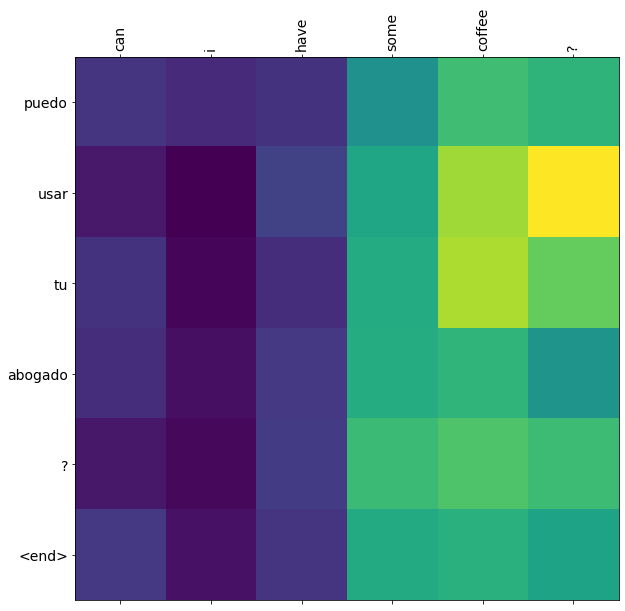

In [ ]:
translate("Can I have some coffee?", encoder, decoder)

# Proj. 한-영 번역기 만들기

한-영 번역기 만들기
1. 데이터 다운로드
- 데이터 : https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1
- korean-english-park.train.tar.gz
2. 데이터 정제
- set 데이터형이 중복이 허용하지 않다는 것을 활용해 중복된 데이터를 제거
  - 데이터 병렬 쌍이 흐트러지지 않게 주의!
  - cleaned_corpus에 저장
- 앞서 정의한 preprocessing()함수는 한글에 대해 동작하지 않아요.
  - 한글에 적용할 수 있는 정규식을 추가해여 함수를 재정의 하세요.
- 타겟 언어인 영문엔 <\start>토큰과 <\end>토큰을 추가하고 split()함수로 토큰화 합니다. 한글 토큰화는 konlpy의 mecab클래스를 사용합니다.
  - cleaned_corpus로부터 토큰의길이가 40이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하기

3. 토큰화
- tokenize()함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요!
  - 단어수는 실험을 통해 적당한 값을 맞춰줍시다(최소 10000이상!)
4. 훈련하기

## 1. 폰트 및 데이터 로드

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

In [3]:
# 자료 가져오기
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz

--2022-05-31 14:39:09--  https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz [following]
--2022-05-31 14:39:09--  https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8718893 (8.3M) [application/octet-stream]
Saving to: ‘korean-english-park.train.tar.gz.1’

korean-e

In [4]:
# 압출 풀기
!tar -xzvf korean-english-park.train.tar.gz                          # 

korean-english-park.train.en
korean-english-park.train.ko


### 한글 파일

In [5]:
# 경로 설정 및 자료 불러오기
path_to_file_ko = './korean-english-park.train.ko'

with open(path_to_file_ko, 'r') as f_ko:
    raw_ko = f_ko.read().splitlines()

# 파일 안의 내용 확인
print('Example : ')
for sen_ko in raw_ko[0:100][: : 20]: print('>>', sen_ko)
print()

print("KO_Data Size : ", len(raw_ko))

Example : 
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.

KO_Data Size :  94123


### 영어 파일

In [6]:
path_to_file_en = './korean-english-park.train.en'

with open(path_to_file_en, "r") as f_en:
    raw_en = f_en.read().splitlines()

print('Example : ')
for sen_en in raw_en[0:100][: : 20]: print('>>', sen_en)
print()

print("EN_Data Size : ", len(raw_en))

Example : 
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.

EN_Data Size :  94123


### 한글 파일과 영어 파일 합치기

In [7]:
data = []

for i in range(len(raw_ko)):
    data.append(raw_ko[i] + '\t' + raw_en[i])

print(len(data))
print(data[20])

94123
북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.	Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.


In [8]:
print('Example : ')
for sen in data[0:100][: : 20]: print('>>', sen)
print()

Example : 
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"	Much of personal computing is about "can you top this?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.	Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."	“Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.	Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.	Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aero

## 2. 데이터 정제

In [9]:
# 중복되는 문장 제거

min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(data))
print('Data Size : ', len(cleaned_corpus))



for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print('문장의 최단 길이 : ', min_len)                             # 한글 파일만 set 했을 경우 -> 77591,   영어 파일만 set 했을 경우 -> 75598
print('문장의 최장 길이 : ', max_len)
print('문장의 평균 길이 : ', sum_len//len(cleaned_corpus))

Data Size :  78968
문장의 최단 길이 :  3
문장의 최장 길이 :  764
문장의 평균 길이 :  198


In [10]:
import numpy as np

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


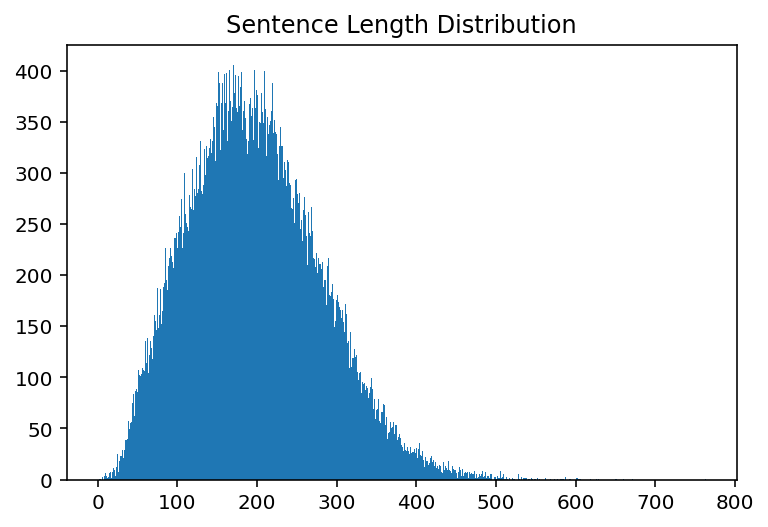

In [11]:
sentence_length = np.zeros((max_len), dtype=np.int)
for sen in cleaned_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width = 1.0)
plt.title('Sentence Length Distribution')
plt.show()

In [12]:
# 한글
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus_ko = list(set(raw_ko))
print('Data Size : ', len(cleaned_corpus_ko))



for sen in cleaned_corpus_ko:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print('문장의 최단 길이 : ', min_len)
print('문장의 최장 길이 : ', max_len)
print('문장의 평균 길이 : ', sum_len//len(cleaned_corpus_ko))

Data Size :  77591
문장의 최단 길이 :  1
문장의 최장 길이 :  377
문장의 평균 길이 :  64


In [13]:
# 영어
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus_en = list(set(raw_en))
print('Data Size : ', len(cleaned_corpus_en))



for sen in cleaned_corpus_en:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print('문장의 최단 길이 : ', min_len)
print('문장의 최장 길이 : ', max_len)
print('문장의 평균 길이 : ', sum_len//len(cleaned_corpus_en))

Data Size :  75598
문장의 최단 길이 :  1
문장의 최장 길이 :  605
문장의 평균 길이 :  134


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


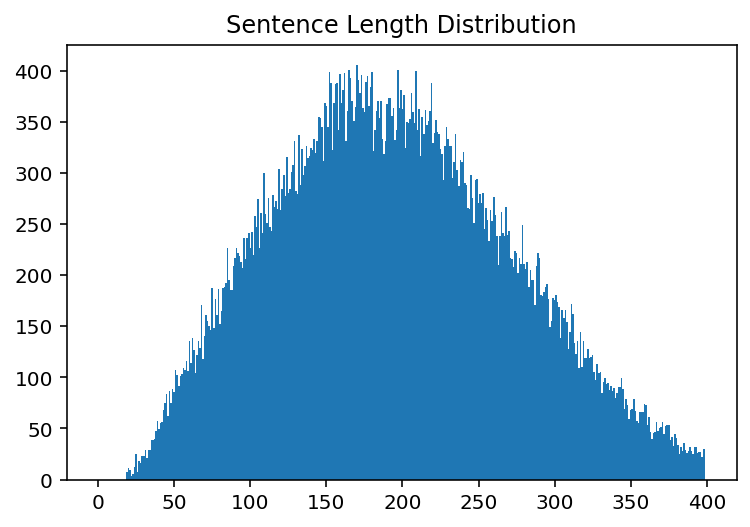

In [14]:
min_len = 20
max_len = 400

filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [15]:
import re

In [16]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,ㄱ-ㅎㅏ-ㅣ가-힣]+", " ", sentence)   # 한글부분 추가

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence
    
    if e_token:
        sentence += ' <end>'

    return sentence

In [17]:
koc_corpus = []
enc_corpus = []

num_examples = 30000                                

for pair in filtered_corpus[:num_examples]:
    kor, eng = pair.split("\t")

    koc_corpus.append(preprocess_sentence(kor))
    enc_corpus.append(preprocess_sentence(eng, s_token=True, e_token=True))            # 영문에 <\start>토큰과 <\end>토큰을 추가

print("Korea :", koc_corpus[100]) # 한글 텍스트
print("English :", enc_corpus[100]) # 영어 텍스트

Korea : 티티 뉴스 tt news 는 올해 세의 애견 판매업자가 피해 여성에게 자신이 동성애자들을 신뢰하지 않으며 이성의 복장을 착용하는 복장도착증 환자들이 애견을 성적으로 학대한다는 보도를 읽은 적이 있어 애견을 판매할 수 없다고 말했다고 보도했다 .
English : <start> the year old kennel owner told the woman she did not trust homosexuals and had read that transvestites sexually abused animals , according to the tt news agency . <end>


## 3. 토큰화 - 여기부터 다시

In [18]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh
%cd ../

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'Mecab-ko-for-Google-Colab' already exists and is not an empty directory.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-05-31 14:39:26--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22e9:9f55, 2406:da00:ff00::22cd:e0db, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?Signature=XdO5lEff8eiagRpIjOow2gbutaQ%3D&Expires=1654008923&AWSAcc

In [19]:
from konlpy.tag import Mecab
import tensorflow as tf

In [20]:
def tokenize_mc(corpus):
    mecab = Mecab()

    return mecab.morphs(corpus)

mecab_corpus = []

for kor in koc_corpus:
    mecab_corpus.append(tokenize_mc(kor))

In [21]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)                                         # 텍스트 -> 시퀀스
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')      # 패딩

    return tensor, tokenizer

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
# 토큰화 : tokenize함수를 사용하여, encoder, decoder 각각을 통과해주세요.
koc_tensor, koc_tokenizer = tokenize(mecab_corpus)
enc_tensor, enc_tokenizer = tokenize(enc_corpus)

# 훈련 데이터와 검증 데이터로 분리하기 (80/20) ---> test_size = 0.2
koc_train, koc_val, enc_train, enc_val = train_test_split(koc_tensor, enc_tensor, test_size=0.2)

print("Korea Vocab Size : ", len(koc_tokenizer.index_word))
print("English Vocab Size : ", len(enc_tokenizer.index_word))

Korea Vocab Size :  34417
English Vocab Size :  30851


## 4. 모델 설계

In [24]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_decoder = tf.keras.layers.Dense(units)
        self.w_encoder = tf.keras.layers.Dense(units)
        self.w_combine = tf.keras.layers.Dense(1)
    
    def call(self, h_encoder, h_decoder):
        # h_enc shape : [batch x length x units]
        # h_dec shape : [batch x units]

        h_encoder = self.w_encoder(h_encoder)

        h_decoder = tf.expand_dims(h_decoder, 1)
        h_decoder = self.w_decoder(h_decoder)

        score = self.w_combine(tf.nn.tanh(h_decoder + h_encoder))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * h_decoder
        context_vector = tf.reduce_sum(context_vector, axis = 1)

        return context_vector, attention_weights

In [25]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, koc_units):
        super(Encoder, self).__init__()
        self.koc_units = koc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(koc_units, return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [26]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Decoder, self).__init__()
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.enc_units)

    def call(self, x, h_dec, koc_out):
        context_vec, attn = self.attention(koc_out, h_dec)
        #print("컨텍스트 벡터의 차원 : ", context_vec.shape) #(64, 1024)
    
        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis= -1)

        out, h_dec = self.gru(out)
        #print("gru 차원 : ", out.shape) #(64, 1, 1024)
        
        out = tf.reshape(out, (-1, out.shape[2])) # (64, 1024)
        #print("변경된 out의 차원 : ", out.shape)
        out = self.fc(out) 
        #print("fc 거친 out의 차원 :", out.shape) # (64, 8894)

        return out, h_dec, attn

In [42]:
# encoder와 decoder 단어장 크기 확인하기
batch_size = 64
src_vocab_size = len(koc_tokenizer.index_word) + 1
tgt_vocab_size = len(enc_tokenizer.index_word) + 1

units = 1024
embedding_dim = 512

encoder = Encoder(src_vocab_size, embedding_dim, units)
decoder = Decoder(tgt_vocab_size, embedding_dim, units)

'''
sample input 
tf. random.uniform으로 만들어서 모델에 들어가는 shape 확인하기 (encoder)
'''
sequence_len = 30

sample_enc = tf.random.uniform((batch_size, sequence_len))
sample_output = encoder(sample_enc)

print('Encoder Output: ', sample_output.shape)

'''
sample input 
tf. random.uniform으로 만들어서 모델에 들어가는 shape 확인하기 (decoder)
'''

sample_state = tf.random.uniform((batch_size, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((batch_size, 1)), sample_state, sample_output)

print('Decoder output :', sample_logits.shape)
print('Decoder Hidden state :', h_dec.shape)
print('Attention :', attn.shape)

Encoder Output:  (64, 30, 1024)
Decoder output : (64, 30852)
Decoder Hidden state : (64, 1024)
Attention : (64, 30, 1)


## 5. 훈련하기

### Optimizer & loss

In [28]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') # 모델 출력값을 그대로 전달한다.

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real,0))
    loss = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss.dtype) # <PAD>
    loss *= mask

    return tf.reduce_mean(loss)

    #[ 0.1 0.2 0.7] ----> 2

### train_step 구하기

train step 학습과정
1. Encoder에 소스 문장을 전달해 컨텍스트 벡터인 koc_out을 생성
2. Decoder에 입력으로 전달할 토큰 문장 생성
3. t=0일 때, Decoder의 Hidden state는 Encoder의 Final state로 정의. h_dec = koc_out[:, -1]
4. 문장과 koc_out, Hidden state를 기반으로 다음단어 (t=1)예측 pred
5. 예측된 단어와 정답간의 loss을 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예측단어X)
6. 반복!

In [44]:
@tf.function # 가속 연산
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape: # 학습하면서 발생한 모든 연산을 기록하는 테이프  # tf.GradientTape() 미분하는 메서드
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

### 훈련 시작하기

In [45]:
from tqdm import tqdm  # tqdm 프로그래스 bar 만들기 -> verbose 대체
import random

epochs = 10

for epoch in range(epochs):
    total_loss = 0

    idx_list = list(range(0, koc_train.shape[0], batch_size))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(koc_train[idx:idx+batch_size],
                                enc_train[idx:idx+batch_size],
                                encoder,
                                decoder,
                                optimizer,
                                enc_tokenizer)
        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

  0%|          | 0/375 [01:33<?, ?it/s]


ResourceExhaustedError: ignored

In [ ]:
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
  bsz = src.shape[0]
  loss =0

  enc_out = encoder(src)
  h_dec = enc_out[:, -1]

  dec_src = tf.expand_dims([dec_tok.word_index['<start>']]* bsz, 1)

  for t in range(1, tgt.shape[1]):
    pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)
    loss += loss_function(tgt[:, t], pred)
    dec_src = tf.expand_dims(tgt[:, t], 1)

  batch_loss = (loss/int(tgt.shape[1]))

  return batch_loss

In [ ]:
# Training Process
from tqdm import tqdm

EPOCHS = 1

for epoch in range(EPOCHS):
  total_loss = 0

  idx_list = list(range(0, koc_train.shape[0], batch_size))
  random.shuffle(idx_list)
  t = tqdm(idx_list)

  for (batch, idx) in enumerate(t):
    batch_loss = train_step(koc_train[idx:idx+batch_size],
                            enc_train[idx:idx+batch_size],
                            encoder,
                            decoder,
                            optimizer,
                            enc_tokenizer)
    total_loss += batch_loss

  t.set_description_str('Epoch %2d' % (epoch +1))
  t.set_postfix_str('Loss %.4f' % (total_loss.numpy()/ (batch+1)))

  test_loss = 0

  idx_list = list(range(0, koc_val.shape[0], batch_size))
  random.shuffle(idx_list)
  t = tqdm(idx_list)

  for (test_batch, idx) in enumerate(t):
    test_batch_loss = eval_step(koc_val[idx:idx+batch_size],
                                enc_val[idx:idx+batch_size],
                                encoder,
                                decoder,
                                enc_tokenizer)
    test_loss += test_batch_loss

  t.set_description_str('Test Epoch %2d' % (epoch+1))
  t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy()/ (test_batch+1)))

In [ ]:
def evaluate(sentence, encoder, decoder):
  attention = np.zeros((enc_train.shape[-1], koc_train.shape[-1]))
  sentence = preprocess_sentence(sentence)
  inputs = koc_tokenizer.texts_to_sequences([sentence.split()])
  inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                         maxlen = koc_train.shape[-1],
                                                         padding= 'post')
  
  result = ''
  koc_out = encoder(inputs)
  enc_hidden = koc_out[:, -1]
  enc_input = tf.expand_dims([enc_tokenizer.word_index['<start>']], 0)

  for t in range(enc_train.shape[-1]):
    predictions, enc_hidden, attention_weights = decoder(enc_input,
                                                         enc_hidden,
                                                         koc_out)
    
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention[t] = attention_weights.numpy()

    predicted_id = \
    tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

    result += enc_tokenizer.index_word[predicted_id] + ' '

    if enc_tokenizer.index_word[predicted_id] == '<end>':
      return result, sentence, attention

    enc_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict = fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence, encoder, decoder):
  result, sentence, attention = evaluate(sentence, encoder, decoder)

  print('Input : %s' % (sentence))
  print('Predicted translation : {}'.format(result))

  attention = attention[:len(result.split()), :len(sentence.split())]
  plot_attention(attention, sentence.split(), result.split(' '))

In [ ]:
translate("Can I have some coffee?", encoder, decoder)